# RNN(Recurrent Neural Network)의 기본 idea<br>
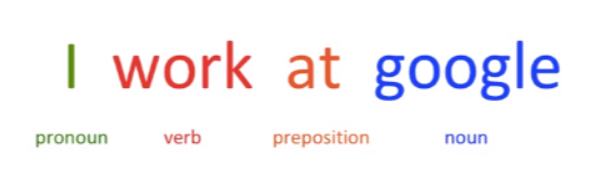<br>
'I'는 주어, 'work'는 동사, 'at'은 전치사, 'google'은 명사라는 건 대부분 알고 있다. 좀 더 구체적으로 들여다보자면 주어인 'I'가 왔기 때문에 그 뒤는 동사일 것이라고 자연스럽게 예측했고, 전치사 'at'이 왔기 때문에 그 뒤는 명사가 올 것이라고 추론할 수 있다. 이러한 일련의 추론 과정을 수학적으로 모델링한 것이 바로 'RNN'이다.

# RNN의 구조
구조는 크게 입력층, 은닉층, 출력층으로 이루어지며, 기본 신경망과의 차이점은 은닉층에서 순환 구조를 가져 순서가 있는 데이터를 처리하는 데 강점을 가진 신경망이라는 점이다.<br>
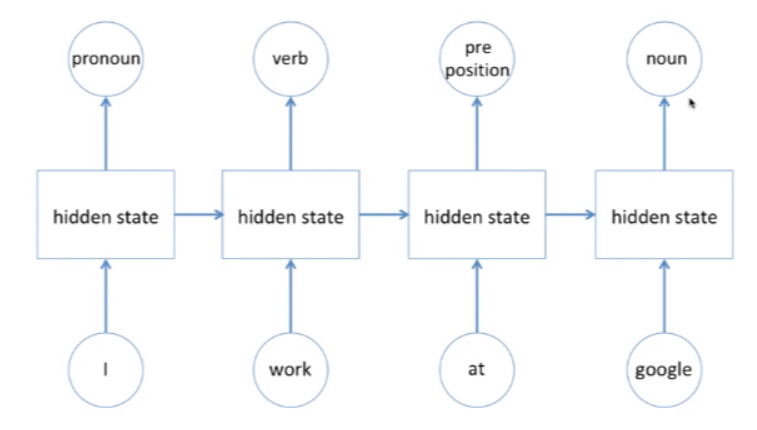<br>
방금 보았던 예시를 4개의 단어를 input으로 받아 품사가 무엇인지 output으로 알려주는 RNN을 다시 표현해본다. input은 동시가 아닌 `순차적`으로 들어오며, 'I'는 `hidden state`라는 것을 거쳐 '주어'라는 것을 미리 알고 있다고 가정한다.<br>
그러면 'I' 다음 'work'를 input으로 받는데, 이 때 hidden state는 'work' 뿐만 아니라 이전 'I'에 대한 데이터를 hidden state를 통해 받아 '동사'라고 판단하게 된다.<br>
마지막으로 'google'이 들어왔을 때는 'google'과 함께 'I', 'work', 'at'에 대한 정보를 함께 조합하여 'google'이 명사일 확률이 높다고 결론을 내린다.<br>

이제 input은 xi, output은 yi, hidden state는 hi로 설정하고 구체적으로 구조를 살펴본다.<br>
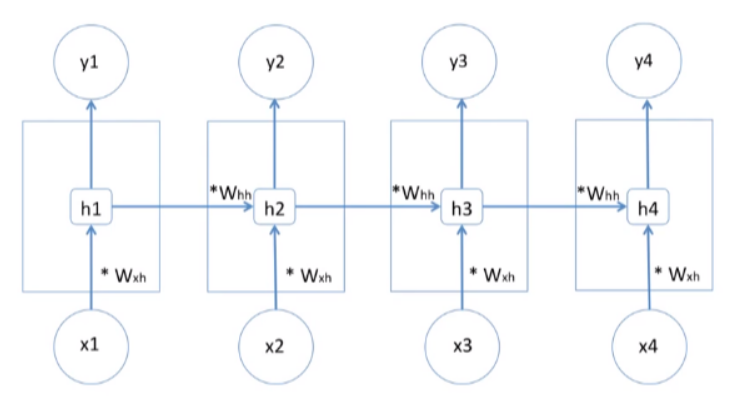<br>
위 그림을 보면 Wxh, Whh가 있는데 이것은 `가중치`이다. 결국 큰 맥락에서 딥러닝의 일종인 RNN은 이전의 input 데이터들을 반영하여 현재의 input 데이터가 무엇인지 판단하는데, 판단의 정확도를 높이기 위해 가중치인 W를 최적화하는 매커니즘을 가지고 있다.

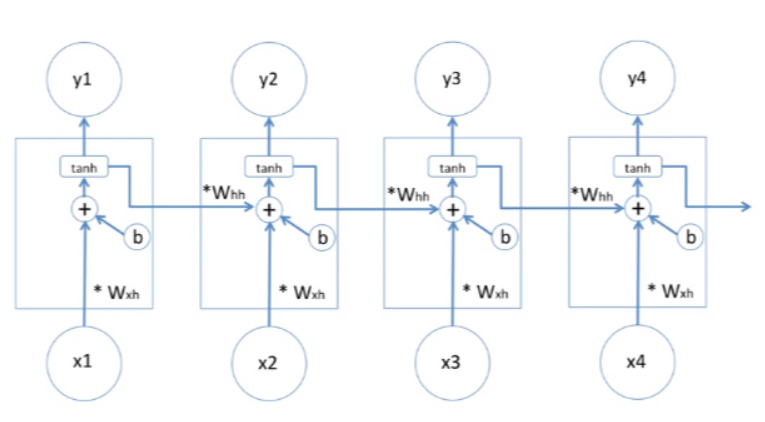<br>
예를 들어 위 그림에서 input으로 x2가 들어왔을 때 hidden state는 x2, 그리고 이전 hidden state를 통해 x1을 받아 output을 출력하게 된다.<br>
이 때 x2는 가중치 Whh가, x1은 가중치 Wxh가 곱해지고 여기에 bias term인 b까지 더해져 만들어진 `Whh * x2 + Wxh * x1 + b`는 `활성함수`인 tanh를 거쳐 최종적인 y2를 도출하게 된다.

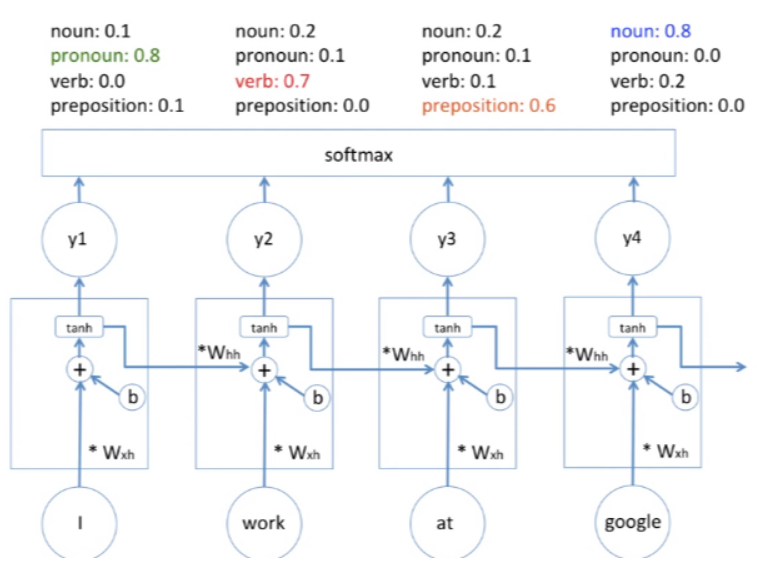<br>
이제 각각 도출한 y값을 활성함수인 softmax에 넣으면 각 단어가 어떤 품사에 해당할지를 확률값으로 알려주고 이 중 제일 확률이 높은 값이 예측값이 된다.<br>

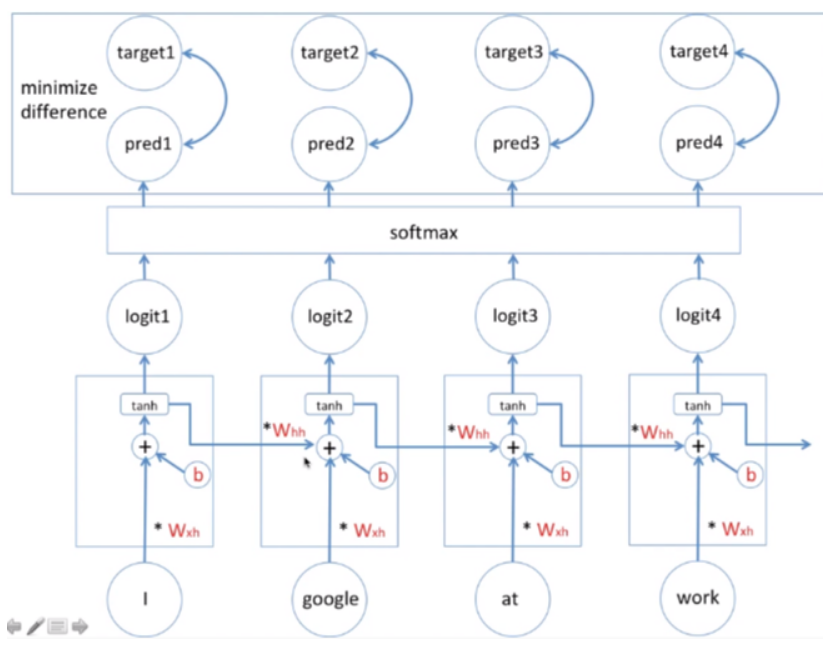<br>
이제 남은 것은 `최적화(Optimization)`이다. 이는 예측값과 실제값의 cost를 줄여나가는 과정을 의미한다. 따라서 Whh, Wxh, b 총 세 가지를 `Gradient Descent Algorithm`을 이용하여 최적화하게 한다.<br>
중요한 점은 위 그림에서 Whh, Wxh, b가 네 개 있는 것처럼 보이지만 실제로는 12개 값이 아닌 3개의 변수라는 점이다.

___

* 모듈 임포트

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import datetime
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
import seaborn as sns

* sqlite DB에서 데이터 불러오기

In [2]:
con = sqlite3.connect(r"C:\Users\gram\OneDrive\바탕 화면\stock_project\stock.db")
df = pd.read_sql("SELECT * FROM '039490'", con, index_col=None)
df.rename(columns={'index':'date'}, inplace=True)
df = df.set_index('date')
df

,open,high,low,close,volume
date,,,,,
20220516,86900,87600,85700,85900,55383
20220513,84000,87400,83500,85800,86525
20220512,84700,85300,82700,83200,104007
20220511,87500,87500,85500,85800,108071
20220510,87500,88600,87000,88000,100350
...,...,...,...,...,...
20040429,5117,5436,5025,5101,109911
20040428,5071,5452,4995,5444,182604
20040427,5452,5482,5033,5063,299489


* 데이터 정렬

In [3]:
df.sort_index(ascending=True, inplace=True)
df

,open,high,low,close,volume
date,,,,,
20040423,6076,6799,5353,5353,1415109
20040426,5436,5741,5261,5398,343283
20040427,5452,5482,5033,5063,299489
20040428,5071,5452,4995,5444,182604
20040429,5117,5436,5025,5101,109911
...,...,...,...,...,...
20220510,87500,88600,87000,88000,100350
20220511,87500,87500,85500,85800,108071
20220512,84700,85300,82700,83200,104007


* 행 인덱스를 datetime 객체로 변환

In [4]:
df.index = pd.DatetimeIndex(df.index)
df.index

DatetimeIndex(['2004-04-23', '2004-04-26', '2004-04-27', '2004-04-28',
               '2004-04-29', '2004-04-30', '2004-05-03', '2004-05-04',
               '2004-05-06', '2004-05-07',
               ...
               '2022-05-02', '2022-05-03', '2022-05-04', '2022-05-06',
               '2022-05-09', '2022-05-10', '2022-05-11', '2022-05-12',
               '2022-05-13', '2022-05-16'],
              dtype='datetime64[ns]', name='date', length=4470, freq=None)

* 이동평균값 계산 및 삽입
 * 이동평균값 : 과거 n일동안의 주가를 다 더해서 평균을 낸 것

In [5]:
# 이동평균값 계산하기
ma5 = df['close'].rolling(window=5).mean() # 5일 이동평균선
ma20 = df['close'].rolling(window=20).mean() # 20일 이동평균선
ma60 = df['close'].rolling(window=60).mean() # 60일 이동평균선 

# 거래량 이동평균값 계산하기
vma20 = df['volume'].rolling(window=20).mean()
vma60 = df['volume'].rolling(window=60).mean()
 
# 새로운 데이터 요소 삽입하기
df['MA5'] = ma5
df['MA20'] = ma20
df['MA60'] = ma60
df['VMA20'] = vma20
df['VMA60'] = vma60

df = df.fillna(0) # 결측값 (=> 0으로 치환할 지 drop할 지 최적의 방법에 대해 고민)

df

,open,high,low,close,volume,MA5,MA20,MA60,VMA20,VMA60
date,,,,,,,,,,
2004-04-23,6076,6799,5353,5353,1415109,0.0,0.0,0.000000,0.00,0.000000
2004-04-26,5436,5741,5261,5398,343283,0.0,0.0,0.000000,0.00,0.000000
2004-04-27,5452,5482,5033,5063,299489,0.0,0.0,0.000000,0.00,0.000000
2004-04-28,5071,5452,4995,5444,182604,0.0,0.0,0.000000,0.00,0.000000
2004-04-29,5117,5436,5025,5101,109911,5271.8,0.0,0.000000,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...
2022-05-10,87500,88600,87000,88000,100350,90960.0,95255.0,97528.333333,50372.25,53293.333333
2022-05-11,87500,87500,85500,85800,108071,89460.0,94620.0,97348.333333,53519.75,54291.016667
2022-05-12,84700,85300,82700,83200,104007,87480.0,93785.0,97120.000000,56481.45,55200.783333


* 주가의 중간값 요소 추가

In [6]:
#가격의 중간값 계산하기
high_prices = df['high'].values
low_prices = df['low'].values
mid_prices = (high_prices + low_prices) / 2

#중간 값 요소 추가하기
df['mid'] = mid_prices 

df

,open,high,low,close,volume,MA5,MA20,MA60,VMA20,VMA60,mid
date,,,,,,,,,,,
2004-04-23,6076,6799,5353,5353,1415109,0.0,0.0,0.000000,0.00,0.000000,6076.0
2004-04-26,5436,5741,5261,5398,343283,0.0,0.0,0.000000,0.00,0.000000,5501.0
2004-04-27,5452,5482,5033,5063,299489,0.0,0.0,0.000000,0.00,0.000000,5257.5
2004-04-28,5071,5452,4995,5444,182604,0.0,0.0,0.000000,0.00,0.000000,5223.5
2004-04-29,5117,5436,5025,5101,109911,5271.8,0.0,0.000000,0.00,0.000000,5230.5
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-10,87500,88600,87000,88000,100350,90960.0,95255.0,97528.333333,50372.25,53293.333333,87800.0
2022-05-11,87500,87500,85500,85800,108071,89460.0,94620.0,97348.333333,53519.75,54291.016667,86500.0
2022-05-12,84700,85300,82700,83200,104007,87480.0,93785.0,97120.000000,56481.45,55200.783333,84000.0


* 주가 시각화

Text(0, 0.5, 'price')

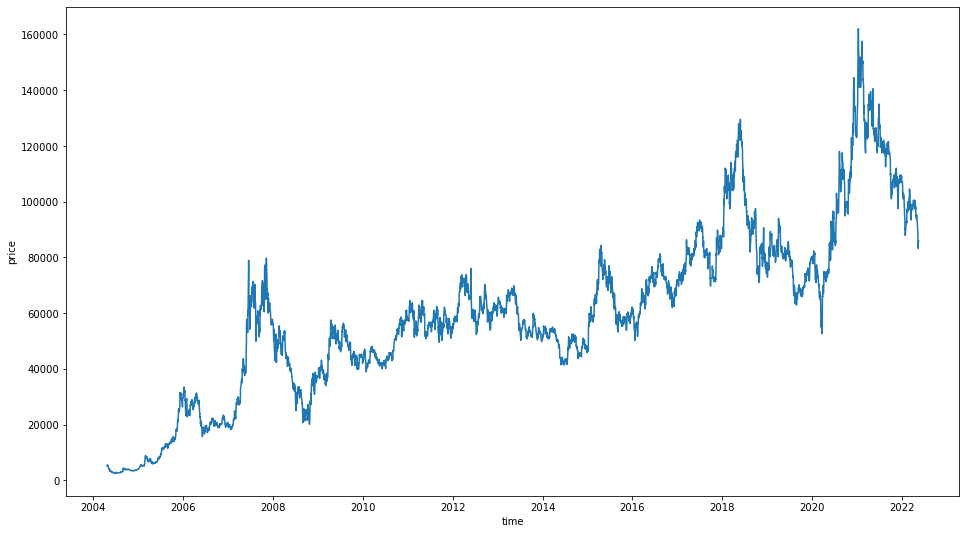

In [5]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

* 골든크로스 : 단기이동평균선이 장기이동평균선을 넘음 (=> 주식이 오르고 있음)
* 데드크로스 : 장기이동평균선이 단기이동평균선을 넘음 (=> 주식이 떨어지고 있음)

In [8]:
gc_point = [] # 골든 크로스 
dc_point =[] # 데드 크로스 

# 모든 값을 0으로 초기화
for i in range(4470): # 4470은 행의 갯수
    gc_point.append(0)
    dc_point.append(0)

In [9]:
index = 0 
for i in range(len(df['MA5'])-1):
    # 5일선과 20일선을 사용하므로 20일 동안은 의미가 없음 
    if index < 20 : 
        pass 
    # 오늘 5일 단기선이 20일 장기선이 보다 작거나 같고, 내일 5일선이 상향돌파 -> 골든 크로스 
    elif df['MA5'][i] <= df['MA20'][i]:
        if df['MA5'][i+1] > df['MA20'][i+1]:
            gc_point[i+1] = 1
        else:
            pass
        
    # 오늘 5일 단기선이 20일 장기선보다 크거나 같고, 내일 5일선이 하향돌파 -> 데드 크로스 
    elif df['MA5'][i] >= df['MA20'][i]:
        if df['MA5'][i+1] < df['MA20'][i+1]:
            dc_point[i+1] = 1
        else:
            pass
    
    index += 1  #index = index + 1

In [10]:
# 골든/데드 크로스 요소 삽입하기 
df.insert(len(df.columns),"GC" , gc_point) # (열 위치, 이름, 데이터)
df.insert(len(df.columns), "DC" , dc_point) 
df = df.fillna(0) # 결측값 (NaN을 0으로 모두 치환)

df

,open,high,low,close,volume,MA5,MA20,MA60,VMA20,VMA60,mid,GC,DC
date,,,,,,,,,,,,,
2004-04-23,6076,6799,5353,5353,1415109,0.0,0.0,0.000000,0.00,0.000000,6076.0,0,0
2004-04-26,5436,5741,5261,5398,343283,0.0,0.0,0.000000,0.00,0.000000,5501.0,0,0
2004-04-27,5452,5482,5033,5063,299489,0.0,0.0,0.000000,0.00,0.000000,5257.5,0,0
2004-04-28,5071,5452,4995,5444,182604,0.0,0.0,0.000000,0.00,0.000000,5223.5,0,0
2004-04-29,5117,5436,5025,5101,109911,5271.8,0.0,0.000000,0.00,0.000000,5230.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-10,87500,88600,87000,88000,100350,90960.0,95255.0,97528.333333,50372.25,53293.333333,87800.0,0,0
2022-05-11,87500,87500,85500,85800,108071,89460.0,94620.0,97348.333333,53519.75,54291.016667,86500.0,0,0
2022-05-12,84700,85300,82700,83200,104007,87480.0,93785.0,97120.000000,56481.45,55200.783333,84000.0,0,0


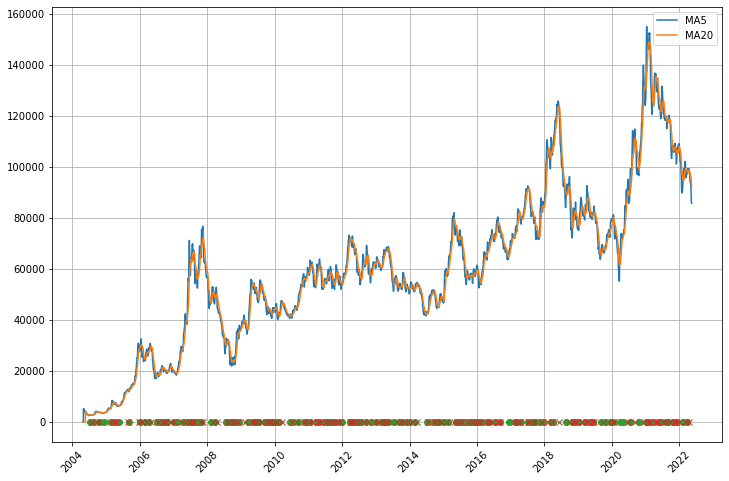

In [11]:
# 이동평균과 골든 / 데드 크로스 시각화
plt.figure(figsize=(12,8)) # 차트 크기 설정
plt.plot(df.index, df['MA5'] , label="MA5")
plt.plot(df.index, df['MA20'] , label="MA20")
plt.plot(df['GC'].iloc[df['GC'].values == True],'o') #골든 크로스 
plt.plot(df['DC'].iloc[df['DC'].values == True],'x') #데드 크로스 
plt.legend(loc='best') #가장 적절한 위치에 설정 
plt.xticks(rotation = 45) #x축 45도 회전 

plt.grid() #격자 
plt.show()

* 데이터 스케일링

In [6]:
# 데이터 스케일링 (preprocessing)

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(df)
output = min_max_scaler.transform(df)

output = pd.DataFrame(output, columns=df.columns, index=list(df.index.values))
print(output.head())

                open      high       low     close    volume
2004-04-23  0.022741  0.026226  0.019066  0.018324  1.000000
2004-04-26  0.018743  0.019815  0.018467  0.018606  0.241077
2004-04-27  0.018842  0.018245  0.016982  0.016507  0.210068
2004-04-28  0.016462  0.018063  0.016734  0.018894  0.127305
2004-04-29  0.016750  0.017967  0.016930  0.016745  0.075834


* 데이터 분리

In [7]:
# train / validation / test size 설정하기
train_size = int(len(output)* 0.6)
validation_size = int(len(output)*0.3) + train_size

# train / test 학습 및 라벨 설정하기
# 종가를 예측하기 위해 종가를 label로 설정
train_x = np.array(output[:train_size])
train_y = np.array(output['close'][:train_size])

validation_x = np.array(output[train_size:validation_size])
validation_y = np.array(output['close'][train_size:validation_size])

test_x = np.array(output[validation_size:])
test_y = np.array(output['close'][validation_size:])

print(len(train_x))
print(len(validation_x))
print(len(test_x))
print(train_x.shape)

2682
1341
447
(2682, 5)


* 하이퍼 파라미터 설정
 * 다루어야 할 데이터가 너무 많고, 한 번의 계산으로 최적화된 값을 찾기 어려움
 * 따라서 최적화를 할 때는 일반적으로 여러 번 학습 과정을 거치고, 한 번의 학습 과정 역시 사용하는 데이터를 나누는 방식으로 세분화시킴
   * epoch : 전체 데이터셋에 대한 반복 학습 횟수, 모델을 만들 때 적절한 epoch 값을 설정해야만 underfitting과 overfitting을 방지, epoch 값이 너무 작다면 underfitting, 너무 크다면 overfitting이 발생할 확률이 높음
   * batch_size : 한 번 학습에 사용할 때마다 주는 데이터 샘플 사이즈
   * iteration : epoch를 나누어서 실행하는 횟수
   * time step : 몇 개의 데이터를 이용해 target 데이터를 예측할 것인지 결정<br>
   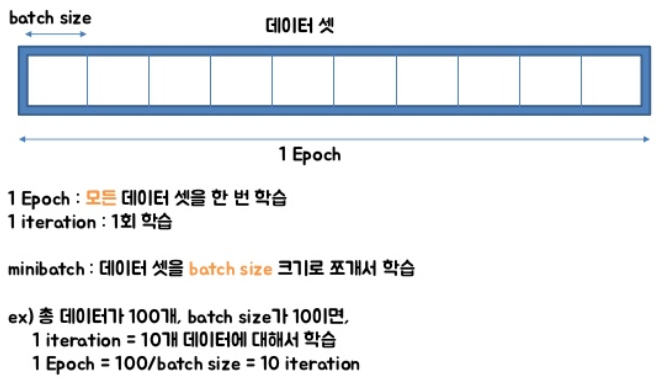<br>

In [8]:
# 학습을 위한 기초 파라메터 설정
learning_rate = 0.01
# 전체 데이터셋에 대한 반복 학습 횟수(500) (Epoch)
training_cnt = 500
# 한번 학습에 사용할 batch size 설정
batch_size =  200
# 입력 피쳐의 개수
input_size = train_x.shape[1]

time_step = 1

* 데이터 변환

In [9]:
# reshape into (size(개수), time step, 입력 feature)
train_x = train_x.reshape(train_x.shape[0], time_step, input_size)
validation_x = validation_x.reshape(validation_x.shape[0], time_step, input_size)
test_x = test_x.reshape(test_x.shape[0], time_step, input_size)

train_x.shape, test_x.shape

((2682, 1, 5), (447, 1, 5))

* RNN 학습
 * Dense는 출력값의 개수
 * Dropout : overfitting을 방지하기 위해 network의 일부를 생략하는 방식<br>
 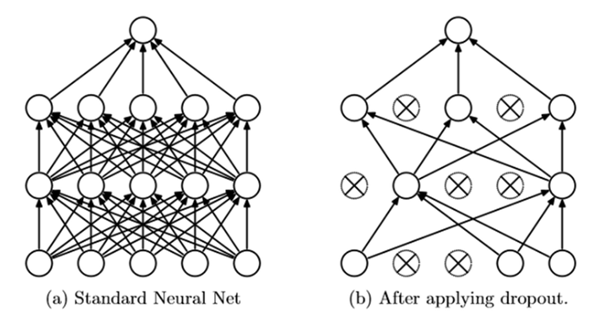<br>
 * optimizer : 훈련 과정을 설정하는 옵티마이저를 설정합니다.
 * loss : 훈련 과정에서 사용할 손실 함수(loss function)를 설정합니다.
 * metrics : 훈련을 모니터링하기 위한 지표를 선택합니다.

In [10]:
model = Sequential()

# hidden_state = output_dim = 512임을 의미
# time_step = 1이므로 1개의 데이터를 이용해서 정답을 만듦
model.add(SimpleRNN(512, input_shape=(time_step, input_size)))

model.add(Dense(1, activation='tanh'))

# Overfitting을 방지하기 위해 Dropout 설정
model.add(Dropout(0.2))

# 오차 및 최적화기 설정하기
# rmsprop : 과거의 모든 기울기를 균일하게 더하지 않고 새로운 기울기의 정보만 반영하도록 해서 학습률이 크게 떨어져 0에 가까워지는 것을 방지
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae', 'mape'])
model.summary()

# 학습하기
history = model.fit(train_x, train_y, epochs=training_cnt, \
                    batch_size = batch_size, verbose=1)
val_mse, val_mae, val_mape = model.evaluate(test_x, test_y, verbose=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 512)               265216    
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
Total params: 265,729
Trainable params: 265,729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
14/14 [==============================] - 4s 21ms/step - loss: 0.0248 - mae: 0.1017 - mape: 38109.1914
Epoch 2/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0165 - mae: 0.0641 - mape: 6563.7017
Epoch 3/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0155 - mae:

14/14 [==============================] - 0s 30ms/step - loss: 0.0148 - mae: 0.0595 - mape: 3768.9854
Epoch 67/500
14/14 [==============================] - 0s 25ms/step - loss: 0.0151 - mae: 0.0617 - mape: 651.4249
Epoch 68/500
14/14 [==============================] - 0s 25ms/step - loss: 0.0145 - mae: 0.0585 - mape: 36.9432
Epoch 69/500
14/14 [==============================] - 0s 25ms/step - loss: 0.0145 - mae: 0.0573 - mape: 145.6645
Epoch 70/500
14/14 [==============================] - 0s 23ms/step - loss: 0.0153 - mae: 0.0603 - mape: 647.2889
Epoch 71/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0151 - mae: 0.0596 - mape: 138.0017
Epoch 72/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0160 - mae: 0.0624 - mape: 35.1654
Epoch 73/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0166 - mae: 0.0633 - mape: 5450.5088
Epoch 74/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0146 - mae: 0.0581 - mape: 279.1

14/14 [==============================] - 0s 14ms/step - loss: 0.0146 - mae: 0.0534 - mape: 666.6186
Epoch 139/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0145 - mae: 0.0543 - mape: 1672.9406
Epoch 140/500
14/14 [==============================] - 0s 17ms/step - loss: 0.0141 - mae: 0.0534 - mape: 796.6143
Epoch 141/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0160 - mae: 0.0582 - mape: 182.8363
Epoch 142/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0150 - mae: 0.0551 - mape: 194.9569
Epoch 143/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0152 - mae: 0.0547 - mape: 2073.1921
Epoch 144/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0141 - mae: 0.0528 - mape: 539.8204
Epoch 145/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0151 - mae: 0.0543 - mape: 559.4274
Epoch 146/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0147 - mae: 0.0539 - m

14/14 [==============================] - 0s 15ms/step - loss: 0.0137 - mae: 0.0493 - mape: 1419.4615
Epoch 210/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0156 - mae: 0.0562 - mape: 30.2180
Epoch 211/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0144 - mae: 0.0533 - mape: 793.6715
Epoch 212/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0139 - mae: 0.0518 - mape: 2479.9912
Epoch 213/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0153 - mae: 0.0548 - mape: 721.2322
Epoch 214/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0161 - mae: 0.0575 - mape: 1308.7935
Epoch 215/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0155 - mae: 0.0566 - mape: 28.5672
Epoch 216/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0151 - mae: 0.0549 - mape: 30.0528
Epoch 217/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0157 - mae: 0.0552 - map

14/14 [==============================] - 0s 23ms/step - loss: 0.0139 - mae: 0.0500 - mape: 28.2973
Epoch 281/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0156 - mae: 0.0549 - mape: 28.9468
Epoch 282/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0153 - mae: 0.0556 - mape: 693.4844
Epoch 283/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0137 - mae: 0.0488 - mape: 941.6075
Epoch 284/500
14/14 [==============================] - 0s 23ms/step - loss: 0.0151 - mae: 0.0526 - mape: 1274.5404
Epoch 285/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0149 - mae: 0.0534 - mape: 33.4464
Epoch 286/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0155 - mae: 0.0544 - mape: 1016.0214
Epoch 287/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0143 - mae: 0.0514 - mape: 1672.8501
Epoch 288/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0146 - mae: 0.0527 - map

14/14 [==============================] - 0s 29ms/step - loss: 0.0153 - mae: 0.0534 - mape: 2113.0869
Epoch 352/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0140 - mae: 0.0509 - mape: 2967.4775
Epoch 353/500
14/14 [==============================] - 0s 30ms/step - loss: 0.0152 - mae: 0.0548 - mape: 1592.9124
Epoch 354/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0150 - mae: 0.0535 - mape: 311.6602
Epoch 355/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0149 - mae: 0.0525 - mape: 1674.9808
Epoch 356/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0166 - mae: 0.0585 - mape: 1758.8943
Epoch 357/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0159 - mae: 0.0572 - mape: 30.1038
Epoch 358/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0152 - mae: 0.0534 - mape: 31.3067
Epoch 359/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0160 - mae: 0.0563 - 

14/14 [==============================] - 0s 25ms/step - loss: 0.0155 - mae: 0.0551 - mape: 1848.5742
Epoch 423/500
14/14 [==============================] - 0s 24ms/step - loss: 0.0149 - mae: 0.0527 - mape: 2048.4915
Epoch 424/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0147 - mae: 0.0519 - mape: 26.9203
Epoch 425/500
14/14 [==============================] - 0s 23ms/step - loss: 0.0136 - mae: 0.0496 - mape: 491.2864
Epoch 426/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0167 - mae: 0.0591 - mape: 215.8704
Epoch 427/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0159 - mae: 0.0559 - mape: 1931.5442
Epoch 428/500
14/14 [==============================] - 0s 23ms/step - loss: 0.0159 - mae: 0.0563 - mape: 353.0400
Epoch 429/500
14/14 [==============================] - 0s 25ms/step - loss: 0.0155 - mae: 0.0550 - mape: 1276.4045
Epoch 430/500
14/14 [==============================] - 0s 24ms/step - loss: 0.0145 - mae: 0.0515 - 

14/14 [==============================] - 0s 21ms/step - loss: 0.0162 - mae: 0.0565 - mape: 1116.8510
Epoch 494/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0155 - mae: 0.0556 - mape: 296.9860
Epoch 495/500
14/14 [==============================] - 0s 35ms/step - loss: 0.0146 - mae: 0.0513 - mape: 422.1860
Epoch 496/500
14/14 [==============================] - 0s 23ms/step - loss: 0.0152 - mae: 0.0537 - mape: 257.9446
Epoch 497/500
14/14 [==============================] - 0s 24ms/step - loss: 0.0150 - mae: 0.0519 - mape: 708.9260
Epoch 498/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0150 - mae: 0.0532 - mape: 186.3703
Epoch 499/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0148 - mae: 0.0529 - mape: 65.8653
Epoch 500/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0142 - mae: 0.0510 - mape: 2395.6130


* epoch에 따른 손실 변화 확인

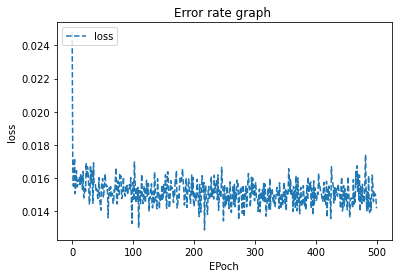

In [11]:
plt.title('Error rate graph ') #plot 제목 설정 
plt.plot(history.history['loss'], linestyle='--') 
plt.legend(['loss'], loc='upper left') #legend 설정
plt.ylabel('loss') #y축 이름 설정 
plt.xlabel('EPoch') #x축 이름 설정 
plt.show()

* 주가 예측

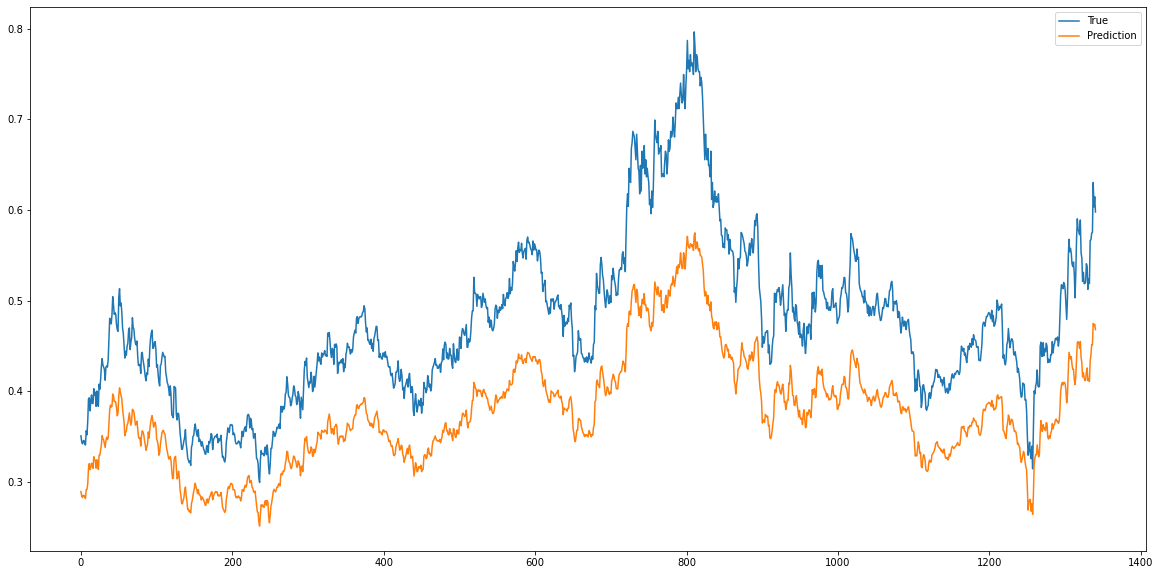

In [12]:
pred = model.predict(validation_x)

fig = plt.figure(facecolor='white', figsize=(20, 10)) #차트의 크기/색 설정 
ax = fig.add_subplot(111)
ax.plot(validation_y, label='True')
ax.plot(pred, label='Prediction')
ax.legend() 
plt.show()

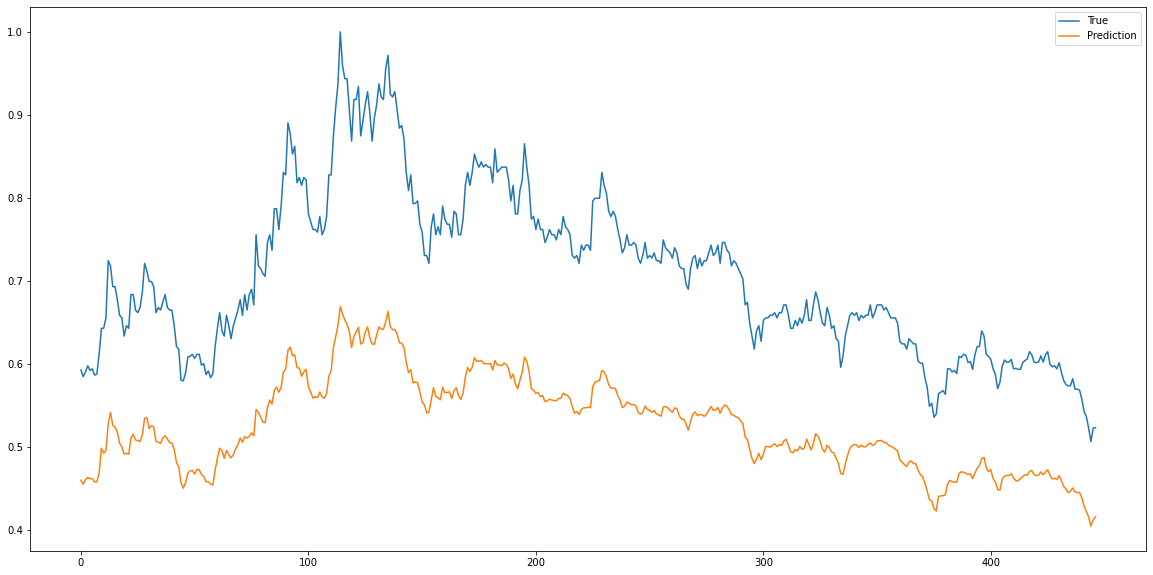

In [13]:
pred = model.predict(test_x)

fig = plt.figure(facecolor='white', figsize=(20, 10)) #차트의 크기/색 설정 
ax = fig.add_subplot(111)
ax.plot(test_y, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

___

In [14]:
model = Sequential()

#cell의 개수와 입력 될 데이터의 shape 설정
model.add(LSTM(512, input_shape=(1,input_size)))

#Overfitting을 방지하기 위해 Dropout 설정
model.add(Dropout(0.2))

#output(target)은 '종가'이기 때문에 1요소 = Dense의 output레이어는 1로 설정
model.add(Dense(1, activation='tanh'))

#오차 및 최적화기 설정하기
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae', 'mape'])
model.summary()

#학습하기
history = model.fit(train_x, train_y, epochs=training_cnt, \
                    batch_size=batch_size, verbose=1)
val_mse, val_mae, val_mape = model.evaluate(test_x, test_y, verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1060864   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,061,377
Trainable params: 1,061,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
14/14 [==============================] - 6s 68ms/step - loss: 0.0184 - mae: 0.1054 - mape: 247.8412
Epoch 2/500
14/14 [==============================] - 1s 67ms/step - loss: 0.0026 - mae: 0.0410 - mape: 43310.4492
Epoch 3/500
14/14 [==============================] - 1s 74ms/step - loss: 9.4409e-

14/14 [==============================] - 1s 68ms/step - loss: 1.4541e-04 - mae: 0.0096 - mape: 1448.3057
Epoch 64/500
14/14 [==============================] - 1s 79ms/step - loss: 1.3285e-04 - mae: 0.0091 - mape: 1652.2321
Epoch 65/500
14/14 [==============================] - 1s 67ms/step - loss: 1.4258e-04 - mae: 0.0095 - mape: 1385.2422
Epoch 66/500
14/14 [==============================] - 1s 66ms/step - loss: 1.5565e-04 - mae: 0.0093 - mape: 1901.4091
Epoch 67/500
14/14 [==============================] - 1s 64ms/step - loss: 1.2401e-04 - mae: 0.0088 - mape: 2776.0303
Epoch 68/500
14/14 [==============================] - 1s 67ms/step - loss: 1.4220e-04 - mae: 0.0096 - mape: 1923.6389
Epoch 69/500
14/14 [==============================] - 1s 66ms/step - loss: 1.4545e-04 - mae: 0.0097 - mape: 696.8863
Epoch 70/500
14/14 [==============================] - 1s 65ms/step - loss: 1.2908e-04 - mae: 0.0089 - mape: 166.3136
Epoch 71/500
14/14 [==============================] - 1s 61ms/step - lo

14/14 [==============================] - 1s 63ms/step - loss: 1.2208e-04 - mae: 0.0087 - mape: 1484.3851
Epoch 133/500
14/14 [==============================] - 1s 56ms/step - loss: 1.2320e-04 - mae: 0.0087 - mape: 1126.6591
Epoch 134/500
14/14 [==============================] - 1s 59ms/step - loss: 1.0317e-04 - mae: 0.0077 - mape: 1995.4523
Epoch 135/500
14/14 [==============================] - 1s 61ms/step - loss: 1.0416e-04 - mae: 0.0080 - mape: 1778.7101
Epoch 136/500
14/14 [==============================] - 1s 62ms/step - loss: 1.0493e-04 - mae: 0.0080 - mape: 896.2544
Epoch 137/500
14/14 [==============================] - 1s 58ms/step - loss: 1.2637e-04 - mae: 0.0089 - mape: 1409.5869
Epoch 138/500
14/14 [==============================] - 1s 65ms/step - loss: 1.1079e-04 - mae: 0.0083 - mape: 1580.4059
Epoch 139/500
14/14 [==============================] - 1s 75ms/step - loss: 1.1254e-04 - mae: 0.0084 - mape: 663.1775
Epoch 140/500
14/14 [==============================] - 1s 81ms/s

14/14 [==============================] - 1s 62ms/step - loss: 9.3729e-05 - mae: 0.0074 - mape: 530.0138
Epoch 202/500
14/14 [==============================] - 1s 64ms/step - loss: 1.0504e-04 - mae: 0.0079 - mape: 653.9229
Epoch 203/500
14/14 [==============================] - 1s 57ms/step - loss: 1.0379e-04 - mae: 0.0080 - mape: 390.7523
Epoch 204/500
14/14 [==============================] - 1s 57ms/step - loss: 1.0522e-04 - mae: 0.0078 - mape: 2483.3467
Epoch 205/500
14/14 [==============================] - 1s 53ms/step - loss: 1.0605e-04 - mae: 0.0079 - mape: 428.9505
Epoch 206/500
14/14 [==============================] - 1s 63ms/step - loss: 9.1417e-05 - mae: 0.0074 - mape: 1049.1855
Epoch 207/500
14/14 [==============================] - 1s 56ms/step - loss: 1.0566e-04 - mae: 0.0082 - mape: 626.4902
Epoch 208/500
14/14 [==============================] - 1s 53ms/step - loss: 8.5736e-05 - mae: 0.0068 - mape: 2189.6101
Epoch 209/500
14/14 [==============================] - 1s 60ms/step

14/14 [==============================] - 1s 79ms/step - loss: 8.5543e-05 - mae: 0.0072 - mape: 814.7666
Epoch 271/500
14/14 [==============================] - 1s 87ms/step - loss: 8.9820e-05 - mae: 0.0074 - mape: 1712.0889
Epoch 272/500
14/14 [==============================] - 1s 92ms/step - loss: 8.5923e-05 - mae: 0.0071 - mape: 2279.2668
Epoch 273/500
14/14 [==============================] - 1s 96ms/step - loss: 8.6937e-05 - mae: 0.0071 - mape: 1459.6610
Epoch 274/500
14/14 [==============================] - 1s 88ms/step - loss: 5.5351e-05 - mae: 0.0055 - mape: 331.3807
Epoch 275/500
14/14 [==============================] - 1s 88ms/step - loss: 9.9772e-05 - mae: 0.0076 - mape: 2643.8135
Epoch 276/500
14/14 [==============================] - 1s 105ms/step - loss: 9.7758e-05 - mae: 0.0079 - mape: 567.4271
Epoch 277/500
14/14 [==============================] - 1s 98ms/step - loss: 8.2472e-05 - mae: 0.0072 - mape: 379.5231
Epoch 278/500
14/14 [==============================] - 2s 120ms/s

14/14 [==============================] - 1s 66ms/step - loss: 7.4811e-05 - mae: 0.0067 - mape: 118.6484
Epoch 340/500
14/14 [==============================] - 1s 74ms/step - loss: 7.3216e-05 - mae: 0.0067 - mape: 101.4210
Epoch 341/500
14/14 [==============================] - 1s 73ms/step - loss: 7.8598e-05 - mae: 0.0070 - mape: 179.4289
Epoch 342/500
14/14 [==============================] - 1s 72ms/step - loss: 8.3914e-05 - mae: 0.0073 - mape: 2125.3713
Epoch 343/500
14/14 [==============================] - 1s 73ms/step - loss: 6.2228e-05 - mae: 0.0058 - mape: 975.9102
Epoch 344/500
14/14 [==============================] - 1s 74ms/step - loss: 7.8199e-05 - mae: 0.0069 - mape: 1315.9272
Epoch 345/500
14/14 [==============================] - 1s 70ms/step - loss: 7.3005e-05 - mae: 0.0065 - mape: 1138.2413
Epoch 346/500
14/14 [==============================] - 1s 73ms/step - loss: 8.6874e-05 - mae: 0.0074 - mape: 816.3611
Epoch 347/500
14/14 [==============================] - 1s 79ms/step

14/14 [==============================] - 1s 68ms/step - loss: 6.9234e-05 - mae: 0.0065 - mape: 2309.8960
Epoch 409/500
14/14 [==============================] - 1s 61ms/step - loss: 7.1655e-05 - mae: 0.0066 - mape: 1113.2335
Epoch 410/500
14/14 [==============================] - 1s 64ms/step - loss: 7.2776e-05 - mae: 0.0067 - mape: 928.2249
Epoch 411/500
14/14 [==============================] - 1s 64ms/step - loss: 7.6846e-05 - mae: 0.0069 - mape: 1420.8373
Epoch 412/500
14/14 [==============================] - 1s 66ms/step - loss: 7.3354e-05 - mae: 0.0066 - mape: 1434.2476
Epoch 413/500
14/14 [==============================] - 1s 62ms/step - loss: 8.1809e-05 - mae: 0.0070 - mape: 355.6655
Epoch 414/500
14/14 [==============================] - 1s 68ms/step - loss: 6.0086e-05 - mae: 0.0059 - mape: 1565.3391
Epoch 415/500
14/14 [==============================] - 1s 67ms/step - loss: 7.1530e-05 - mae: 0.0067 - mape: 677.7276
Epoch 416/500
14/14 [==============================] - 1s 63ms/st

14/14 [==============================] - 2s 117ms/step - loss: 5.9926e-05 - mae: 0.0059 - mape: 698.8494
Epoch 478/500
14/14 [==============================] - 1s 86ms/step - loss: 5.7932e-05 - mae: 0.0059 - mape: 1333.7733
Epoch 479/500
14/14 [==============================] - 1s 80ms/step - loss: 6.0600e-05 - mae: 0.0062 - mape: 2312.1013
Epoch 480/500
14/14 [==============================] - 1s 86ms/step - loss: 6.4131e-05 - mae: 0.0064 - mape: 1354.6936
Epoch 481/500
14/14 [==============================] - 1s 98ms/step - loss: 6.1203e-05 - mae: 0.0061 - mape: 405.0453
Epoch 482/500
14/14 [==============================] - 1s 89ms/step - loss: 5.6056e-05 - mae: 0.0056 - mape: 1329.2513
Epoch 483/500
14/14 [==============================] - 1s 92ms/step - loss: 7.0944e-05 - mae: 0.0064 - mape: 73.8326
Epoch 484/500
14/14 [==============================] - 1s 88ms/step - loss: 7.3116e-05 - mae: 0.0066 - mape: 930.2348
Epoch 485/500
14/14 [==============================] - 1s 88ms/ste

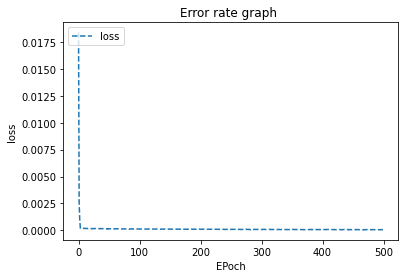

In [15]:
plt.title('Error rate graph ') #차트 제목 설정 
plt.plot(history.history['loss'], linestyle='--')
plt.legend(['loss'], loc='upper left') #legend 설정
plt.ylabel('loss') #y축 설정 
plt.xlabel('EPoch') #x축 설정 
plt.show()

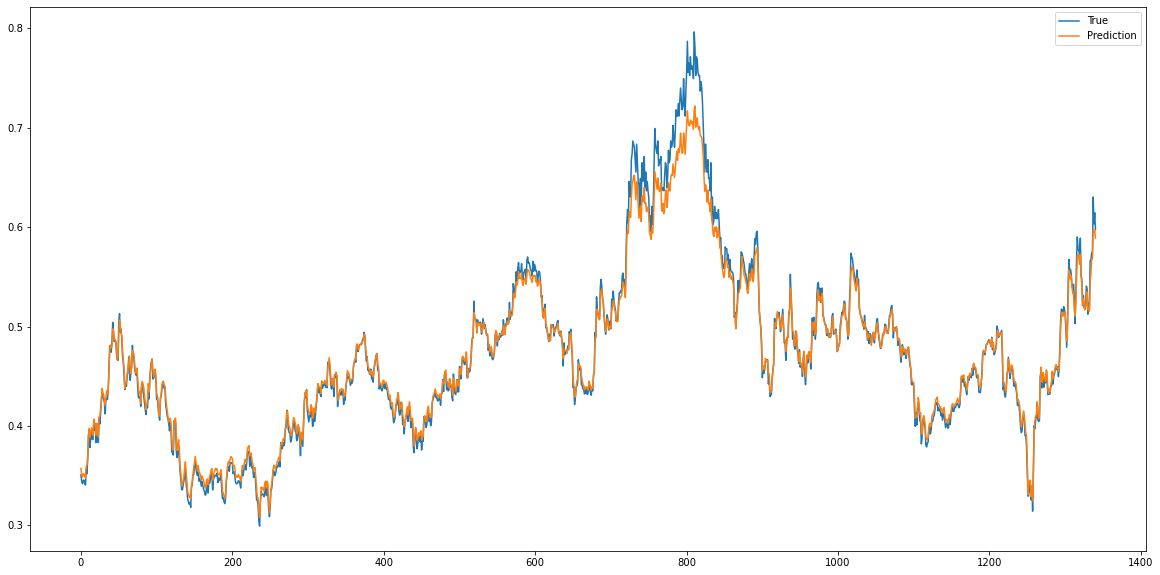

In [16]:
pred = model.predict(validation_x)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(validation_y, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

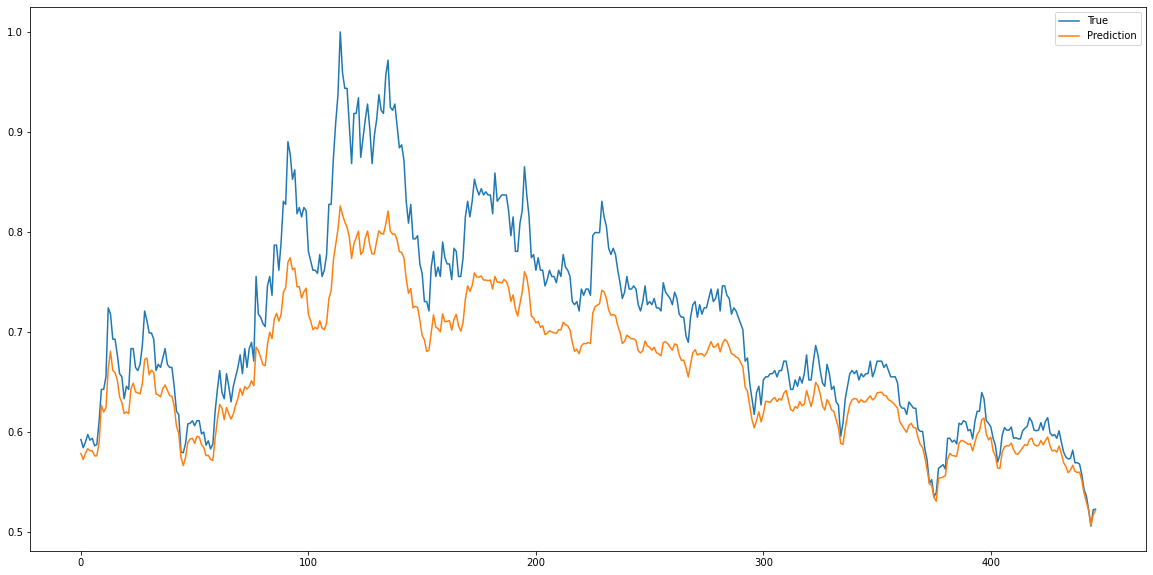

In [17]:
pred = model.predict(test_x)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(test_y, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()